In [1]:
import torch
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

#### 反向累积总结
     - 1.forward propagation执行图存储中间结果
     - 2.backward propagation 利用之前存储的结果从相反方向执行图并去除不需要的枝

In [2]:
x.requires_grad_(True)   ##需要一个地方来存储x的梯度
x.grad

In [3]:
y = 2*torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

In [4]:
y.backward()   ####调用反向传播来计算x的梯度因为计算梯度的成本很高所以除非调用反向传播明确告诉计算机需要梯度否则不会计算梯度
x.grad

tensor([ 0.,  4.,  8., 12.])

In [5]:
x.grad == 4*x

tensor([True, True, True, True])

In [7]:
#### 想要换一个关于x的函数，但是在默认情况下，pytorch会累积梯度，所以我们需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

如果一个向量是常数向量，不管向量中的常数元素是否相同，那么对sum（x）求梯度得到的向量一定是全1的向量

#### 深度学习中一般常用的是标量对向量求导

note：将某些计算移动到记录的计算图之外

In [8]:
x.grad.zero_()
y = x*x
u = y.detach()  #将变量y从计算图中分离出来，生成一个新的张量u，使得u不再与计算图相关联，即不再具有梯度信息
z = u*x

z.sum().backward()
x.grad

tensor([0., 1., 4., 9.])

In [9]:
x.grad ==u

tensor([True, True, True, True])

### 线性回归从零开始实现

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## Step1

In [3]:
#### 使用线性模型W=[2,-3.4]T  b=4.2 和噪声项ξ生成人造数据集及其标签
def synthetic_data(w,b,num_examples):
    """生成 y = Xw+b+噪声"""
    X = torch.normal(0,1,(num_examples,len(w))) #X是一个num_examples行，len(w)列 的矩阵 
    y = torch.matmul(X, w)+b
    y += torch.normal(0,0.01,y.shape)           #加上一个随机的噪声
    return X,y.reshape((-1,1))
    
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)  #生成了1000个样本

features: tensor([-0.5613, -0.4774]) 
labels: tensor([4.7226])


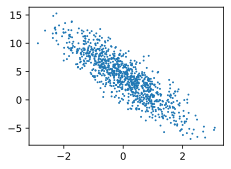

In [4]:
###features 中每一行都包含一个二维数据样本，labels中每一行都包含一个一维标签值
print('features:',features[0],'\nlabels:',labels[0])
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),
               labels.detach().numpy(),1)

## Step2:

In [5]:
### 定义一个data_iter函数接受批量大小（batch）特征矩阵（X）和标签向量（y）作为输入
### 生成大小为batch_size的小批量

def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples)) ##生成索引
    ####将样本打乱后随机读取(索引的顺序发生改变 )
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):  #按照indice中索引的索引进行顺序取数但是抽取的batch由于shuffle变成随机的了
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

batch_size = 10

for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break  ####为了只展示一次抽取的结果直接break了

tensor([[-0.0220, -1.1913],
        [ 0.6743,  0.7410],
        [ 0.3782,  0.0060],
        [ 1.0169,  1.6069],
        [ 1.5962,  1.7431],
        [-0.4110,  2.1180],
        [-0.8044, -0.0234],
        [-0.4601, -1.5625],
        [ 0.0320,  0.6565],
        [-0.4413, -0.8385]]) 
 tensor([[ 8.1920],
        [ 3.0424],
        [ 4.9449],
        [ 0.7565],
        [ 1.4635],
        [-3.8089],
        [ 2.6715],
        [ 8.5997],
        [ 2.0341],
        [ 6.1676]])


In [17]:
###易读
num_examples=20
batch_size=4
indices = list(range(num_examples)) ##生成索引
    ####将样本打乱后随机读取(索引的顺序发生改变)
random.shuffle(indices)
for i in range(0,num_examples,batch_size):
    batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
    print(batch_indices)

print(indices)

tensor([ 6, 12,  4,  2])
tensor([19,  0,  3,  1])
tensor([14, 13, 11,  5])
tensor([ 9, 15, 17, 18])
tensor([ 8,  7, 10, 16])
[6, 12, 4, 2, 19, 0, 3, 1, 14, 13, 11, 5, 9, 15, 17, 18, 8, 7, 10, 16]


In [22]:
###定义初始化模型参数
w = torch.normal(0,0.01,size = (2,1),requires_grad = True)
b = torch.zeros(1,requires_grad = True)

In [23]:
####定义线性回归模型(模型设计)
def linreg(X,w,b):
    """
    线性回归模型
    """
    return torch.matmul(X,w)+b

###定义损失函数
def squared_loss(y_hat,y):
    """
    均方损失MSE
    """
    return (y_hat-y.reshape(y_hat.shape))**2/2

####定义优化算法-梯度下降
def sgd(params,lr,batch_sie):  #### lr:学习率α 
    """
    小批量随机梯度下降
    """
    with torch.no_grad():
        for param in params:
            param -=lr*param.grad/batch_size
            param.grad.zero_()

In [24]:
###模型训练
lr = 0.03
num_epochs=3
net = linreg
loss=squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)

    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch+1},loss{float(train_l.mean()):f}')

epoch1,loss0.041558
epoch2,loss0.000158
epoch3,loss0.000053


### 深度学习的简洁实现

In [27]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [26]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = d2l.synthetic_data(true_w,true_b,1000)

In [35]:
#### 如何随机抽取样本
def load_array(data_arrays,batch_size,is_train = True):
    """
    构造一个pytorch数据迭代器，在数据集中随机抽取batch
    """
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle = is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 5.0366e-01, -1.2853e-01],
         [-6.9348e-01,  9.5204e-01],
         [-1.5482e-01, -9.0386e-01],
         [-1.8177e-01, -1.2030e-03],
         [ 1.2960e+00,  9.0210e-02],
         [ 5.8332e-01,  1.0430e-01],
         [ 3.8562e-01, -1.7123e+00],
         [ 1.1966e-01,  5.2698e-01],
         [-4.8493e-01, -8.8946e-01],
         [ 1.5174e+00,  9.0502e-01]]),
 tensor([[ 5.6627],
         [-0.4340],
         [ 6.9620],
         [ 3.8393],
         [ 6.4756],
         [ 5.0072],
         [10.8121],
         [ 2.6373],
         [ 6.2681],
         [ 4.1659]])]

In [40]:
#### 模型定义
from torch import nn
net = nn.Sequential(nn.Linear(2,1))

#### 损失函数：计算均方误差
loss = nn.MSELoss()

#### 实例化SGD实例
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

In [41]:
#### 初始化模型参数

net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [42]:
#### 训练模型
num_epochs = 3

for epoch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)
    print(f'epoch{epoch+1}, loss{l:f}')

epoch1, loss0.000193
epoch2, loss0.000090
epoch3, loss0.000090
